## Common Constants

In [182]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

CAR = 1285; #from spurce specs
tci = 500e-12;#from source specs
epol = 0.02;#typical for similar setups

B = 1/(CAR*tci); #From Neumann's paper

loss = 13.6; #estimate of our setup
eta = 10**(-loss/10);

# Prepare Data Files

## Tranform Data

In [ ]:
def transform_data(AH, AV, AD, AA, BH, BV, BD, BA):
    # Combine all input arrays into a single 2D array
    data = np.array([AH, AV, AD, AA, BH, BV, BD, BA], dtype=np.uint8).T

    # Find rows where at least one bit is 1
    valid_rows = np.any(data, axis=1)

    # Get the indices of valid rows
    indices = np.where(valid_rows)[0]

    # Compute pulse_select values for valid rows
    binary_values = data[valid_rows]
    # Convert each row of binary values to a single byte (0-255)
    pulse_select = np.packbits(binary_values, axis=1).flatten()

    # Compute Time_Offset for valid rows
    Time_Offset = indices - np.append([-1], indices[:-1])
    #Time_Offset = Time_Offset.astype(np.uint8)  # Ensure values fit in 1 byte (0–255)

    return pulse_select, Time_Offset

## Save Data Files as TXT 

In [ ]:
def write_pulse_time_to_file(filename, pulse_select, time_offset, columns_per_line=4):
    """
    Writes pulse_select (in hex) and time_offset (in decimal) values to a formatted text file.

    Parameters:
        filename (str): The name of the output file.
        pulse_select (list or array): List of pulse select values.
        time_offset (list or array): List of time offset values.
        columns_per_line (int): Number of pairs to write per line.
    """
    with open(filename, "w") as f:
        for i in range(0, len(pulse_select), columns_per_line):
            # Slice the current line's data
            pulse_slice = pulse_select[i:i + columns_per_line]
            time_slice = time_offset[i:i + columns_per_line]

            # Format each pair and join them with spaces
            line = ' '.join(f"{pulse:02X} {time}" for pulse, time in zip(pulse_slice, time_slice))

            # Write the line to the file
            f.write(line + "\n")

    print(f"File '{filename}' written successfully.")

## Generate Periodic Data

In [ ]:
period = 10; # number of nanoseconds between each pulse_select. MUST BE GREATER THAN DEAD TIME
N = 125000*period; # Number of 64 bit (8 bytes = 4 pulse_data bytes and 4 Time_Offset bytes) elements to be generated 125k = 1MB
# Pre-allocate arrays
AH = np.zeros(int(N*4), dtype=np.uint8)
AV = np.zeros(int(N*4), dtype=np.uint8)
AD = np.zeros(int(N*4), dtype=np.uint8)
AA = np.zeros(int(N*4), dtype=np.uint8)
BH = np.zeros(int(N*4), dtype=np.uint8)
BV = np.zeros(int(N*4), dtype=np.uint8)
BD = np.zeros(int(N*4), dtype=np.uint8)
BA = np.zeros(int(N*4), dtype=np.uint8)


active_1 = np.array([1, 1, 1, 1, 1, 1, 1, 1]);
active_2 = np.array([1, 1, 1, 1, 1, 1, 1, 1]);
active_3 = np.array([1, 1, 1, 1, 1, 1, 1, 1]);
active_4 = np.array([1, 1, 1, 1, 1, 1, 1, 1]);
active_5 = np.array([1, 1, 1, 1, 1, 1, 1, 1]);
active_6 = np.array([1, 1, 1, 1, 1, 1, 1, 1]);
active_7 = np.array([1, 1, 1, 1, 1, 1, 1, 1]);
active_8 = np.array([1, 1, 1, 1, 1, 1, 1, 1]);


# active_1 = np.array([1, 0, 0, 0, 0, 0, 0, 0]);
# active_2 = np.array([0, 1, 0, 0, 0, 0, 0, 0]);
# active_3 = np.array([0, 0, 1, 0, 0, 0, 0, 0]);
# active_4 = np.array([0, 0, 0, 1, 0, 0, 0, 0]);
# active_5 = np.array([0, 0, 0, 0, 1, 0, 0, 0]);
# active_6 = np.array([0, 0, 0, 0, 0, 1, 0, 0]);
# active_7 = np.array([0, 0, 0, 0, 0, 0, 1, 0]);
# active_8 = np.array([0, 0, 0, 0, 0, 0, 0, 1]);

active_detectors = [active_1, active_2, active_3, active_4, active_5, active_6, active_7, active_8];
N_bursts = len(active_detectors);

#active_detectors = np.array([1, 1, 1, 1, 1, 1, 1, 1]); # if 1 detector is active 0 if not. From lect to right: AH, AV, AD, AA, BH, BV, BD, BA.

for i in range(N_bursts):
    active_indices = np.arange(int(i*N/2), int(i*N/2 + N/2), period);
    
    # Vectorized assignments based on active detectors
    if active_detectors[i][0]: AH[active_indices] = 1
    if active_detectors[i][1]: AV[active_indices] = 1
    if active_detectors[i][2]: AD[active_indices] = 1
    if active_detectors[i][3]: AA[active_indices] = 1
    if active_detectors[i][4]: BH[active_indices] = 1
    if active_detectors[i][5]: BV[active_indices] = 1
    if active_detectors[i][6]: BD[active_indices] = 1
    if active_detectors[i][7]: BA[active_indices] = 1


pulse_select, Time_Offset = transform_data(AH, AV, AD, AA, BH, BV, BD, BA)
filename = 'Test_all_active_2.txt';
write_pulse_time_to_file(filename, pulse_select, Time_Offset, columns_per_line=4)
    

## Detection Function with Jitter

In [183]:
def detect(timetag, n, mu=0, sigma=0.5):
    normal = np.random.normal(mu, sigma, n)
    return np.floor(timetag / 10 + normal).astype(np.int32)

# Random Generation

In [246]:
run_time = 0.1; #seconds
delay = 35; #artificial delay in ns
mu = 0; #mean of normal distribution for accounting for detector jitter which is 1 ns
sigma = 0.5 #1 ns jitter for our detectors

# Generate random data
Coin = np.random.poisson(B * run_time, 1)[0]  # Number of expected coincidences
N = int(run_time * 1e10)  # Number of bins
P_coin = Coin / N  # Probability of getting a coincidence pair
P = np.random.uniform(0, 1, N)
Coin_loc = np.where(P <= P_coin)[0]
n_Coin = len(Coin_loc)

# Jitter detection times
Coin_Detection_Times_A = detect(Coin_loc,n_Coin); #This is the actual time the detections arrive for Alice including detector jitter. 
Coin_Detection_Times_B = detect(Coin_loc,n_Coin); #This is the actual time the detections arrive for Bob including detector jitter. 
# Coin_Detection_Times_A = np.floor(Coin_loc / 10 + np.random.normal(mu, sigma, n_Coin)).astype(np.int32)
# Coin_Detection_Times_B = np.floor(Coin_loc / 10 + np.random.normal(mu, sigma, n_Coin)).astype(np.int32) + delay

# Probabilities
P_A = np.random.uniform(0,1,n_Coin); #P that a photon made it to Alice's detection setup given eta
P_B = np.random.uniform(0,1,n_Coin); #P that a photon made it to Bob's detection setup given eta
P_A_Basis = np.random.uniform(0,1,n_Coin);#P of choosing the HV basis ( P<=0.5) or DA basis (P > 0.5) for Alice
P_B_Basis = np.random.uniform(0,1,n_Coin);#P of choosing the HV basis ( P<=0.5) or DA basis (P > 0.5) for Bob
P_State = np.random.uniform(0,1,n_Coin);#P of getting the state HV (P<= 0.5) of the state VH (P > 0.5)
P_Error_A = np.random.uniform(0,1,n_Coin);#P of getting a polarization error in Alice's setup
P_Error_B = np.random.uniform(0,1,n_Coin);#P of getting a polarization error in Bob's setup

# Pre-allocate arrays
AH = np.zeros(int(run_time * 1e9), dtype=np.uint8)
AV = np.zeros(int(run_time * 1e9), dtype=np.uint8)
AD = np.zeros(int(run_time * 1e9), dtype=np.uint8)
AA = np.zeros(int(run_time * 1e9), dtype=np.uint8)
BH = np.zeros(int(run_time * 1e9), dtype=np.uint8)
BV = np.zeros(int(run_time * 1e9), dtype=np.uint8)
BD = np.zeros(int(run_time * 1e9), dtype=np.uint8)
BA = np.zeros(int(run_time * 1e9), dtype=np.uint8)

# Vectorized processing for Alice
alice_indices = np.where(P_A <= eta)[0]
detection_times_a = Coin_Detection_Times_A[alice_indices]

HV_mask = P_A_Basis[alice_indices] <= 0.5
DA_mask = ~HV_mask
HV_state = P_State[alice_indices] <= 0.5
VH_state = ~HV_state
no_error_a = P_Error_A[alice_indices] > epol
error_a = ~no_error_a

# Process HV Basis
AH[detection_times_a[HV_mask & HV_state & no_error_a]] = 1
AV[detection_times_a[HV_mask & VH_state & no_error_a]] = 1
AH[detection_times_a[HV_mask & VH_state & error_a]] = 1
AV[detection_times_a[HV_mask & HV_state & error_a]] = 1

AHT = np.sort(np.append(detection_times_a[HV_mask & HV_state & no_error_a], detection_times_a[HV_mask & VH_state & error_a]), axis = None)
AVT = np.sort(np.append(detection_times_a[HV_mask & VH_state & no_error_a], detection_times_a[HV_mask & HV_state & error_a]), axis = None)


# Process DA Basis
AD[detection_times_a[DA_mask & HV_state & no_error_a]] = 1
AA[detection_times_a[DA_mask & VH_state & no_error_a]] = 1
AD[detection_times_a[DA_mask & VH_state & error_a]] = 1
AA[detection_times_a[DA_mask & HV_state & error_a]] = 1

ADT = np.sort(np.append(detection_times_a[DA_mask & HV_state & no_error_a], detection_times_a[DA_mask & VH_state & error_a]), axis = None)
AAT = np.sort(np.append(detection_times_a[DA_mask & VH_state & no_error_a], detection_times_a[DA_mask & HV_state & error_a]), axis = None)

# Vectorized processing for Bob
bob_indices = np.where(P_B <= eta)[0]
detection_times_b = Coin_Detection_Times_B[bob_indices] + delay

HV_mask_b = P_B_Basis[bob_indices] <= 0.5
DA_mask_b = ~HV_mask_b
HV_state_b = P_State[bob_indices] <= 0.5
VH_state_b = ~HV_state_b
no_error_b = P_Error_B[bob_indices] > epol
error_b = ~no_error_b

# Process HV Basis
BV[detection_times_b[HV_mask_b & HV_state_b & no_error_b]] = 1
BH[detection_times_b[HV_mask_b & VH_state_b & no_error_b]] = 1
BV[detection_times_b[HV_mask_b & VH_state_b & error_b]] = 1
BH[detection_times_b[HV_mask_b & HV_state_b & error_b]] = 1
BVT = np.sort(np.append(detection_times_b[HV_mask_b & HV_state_b & no_error_b], detection_times_b[HV_mask_b & VH_state_b & error_b]), axis = None)
BHT = np.sort(np.append(detection_times_b[HV_mask_b & VH_state_b & no_error_b], detection_times_b[HV_mask_b & HV_state_b & error_b]), axis = None)



# Process DA Basis
BA[detection_times_b[DA_mask_b & HV_state_b & no_error_b]] = 1
BD[detection_times_b[DA_mask_b & VH_state_b & no_error_b]] = 1
BA[detection_times_b[DA_mask_b & VH_state_b & error_b]] = 1
BD[detection_times_b[DA_mask_b & HV_state_b & error_b]] = 1

BAT = np.sort(np.append(detection_times_b[DA_mask_b & HV_state_b & no_error_b], detection_times_b[DA_mask_b & VH_state_b & error_b]), axis = None)
BDT = np.sort(np.append(detection_times_b[DA_mask_b & VH_state_b & no_error_b], detection_times_b[DA_mask_b & HV_state_b & error_b]), axis = None)



pulse_select, Time_Offset = transform_data(AH, AV, AD, AA, BH, BV, BD, BA)
# Normalize Time_Offset to the range 1-256
Time_Offset = np.min((Time_Offset % 256),1)  # Modulo 256 and shift to range 1-256
filename = 'Test_random_active.txt';
write_pulse_time_to_file(filename, pulse_select, Time_Offset, columns_per_line=4)


File 'Test_random_active.txt' written successfully.


## Test area for random generation

## Test Peak Finder

In [185]:
counter = 0;
for i in range(n_Coin):
    if P_A[i] < eta and P_B[i] < eta and P_A_Basis[i] > 0.5 and P_B_Basis[i] > 0.5 and P_Error_B[i] > epol and P_Error_A[i] > epol and P_State[i] > 0.5:
        # print(Coin_Detection_Times_A[i])
        # print(Coin_Detection_Times_B[i])
        counter += 1;
print(counter);

21


In [186]:
# Pre-allocate arrays
AH_1 = AH
AV_1 = AV
AD_1 = AD
AA_1 = AA
BH_1 = BH
BV_1 = BV
BD_1 = BD
BA_1 = BA

In [191]:
AHT

[]

In [247]:
Alice = AHT;
Bob = BVT;

diffs = np.zeros(len(Alice)*len(Bob));

for i in range(len(Alice)):
    for j in range(len(Bob)):
        diff = Alice[i] - Bob[j];
        diffs[i*len(Bob) + j] = diff;

In [248]:
bin_size = 1; #bin size in ns
range_max = 1e6; #maximum delay to look for in ns (ex. 1e6 = 1 ms)
hist = np.zeros(2*int(range_max/bin_size)); #number of bins

hist_max = 0;
hist_max_idx = 0;

for k in range(len(diffs)):
    if np.abs(diffs[k]) < range_max:
        hist_idx = int(np.floor(diffs[k]/bin_size + range_max/bin_size));
        hist[hist_idx] += 1;
        
        if hist[hist_idx] > hist_max:
            hist_max = hist[hist_idx];
            hist_max_idx = hist_idx;

print(hist_max);
print(hist_max_idx-range_max/bin_size);

19.0
-35.0


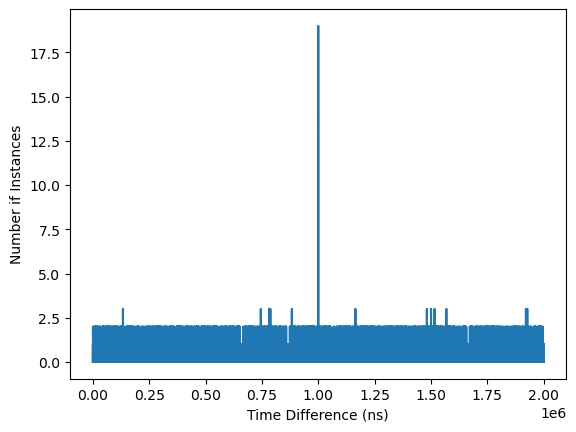

In [249]:
plt.plot(hist)
# plt.plot(hist,'.')
plt.xlabel('Time Difference (ns)');
plt.ylabel('Number if Instances');

In [112]:
.30check = 492041
start = check - 5
end = check + 5

print(AH[start:end])
print(AV[start:end])
print(AD[start:end])
print(AA[start:end])

print(BH[start + delay:end + delay])
print(BV[start + delay:end + delay])
print(BD[start + delay:end + delay])
print(BA[start + delay:end + delay])

[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 1 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]


In [18]:
my_str = ''
test =np.array([0,0,0,0,0,1,1,1])

for k in range(len(test)):
    my_str += str(test[k])

print(my_str)

00000111


In [20]:
int(my_str,2)

7

In [98]:
pulse_select, Time_Offset = transform_data(AH, AV, AD, AA, BH, BV, BD, BA)

### Normalize Time Offset to be between 1-256

In [ ]:
# Normalize Time_Offset to the range 1-256
#Time_Offset = (Time_Offset % 256) + 1  # Modulo 256 and shift to range 1-256

## Test Area

In [104]:
filename = 'test.txt'

write_pulse_time_to_file(filename, pulse_select, Time_Offset, columns_per_line=4)

File 'test.txt' written successfully.


In [155]:
len(pulse_select)

20372

File 'Test_all_active_2.txt' written successfully.


## Test Area

In [158]:
x = np.array([[1,2],[3,4]])

In [160]:
x[0]

1

In [175]:
len(Time_Offset)

500000

In [176]:
len(pulse_select)

500000

In [164]:
pulse_select

array([255, 255, 255, ..., 255, 255, 255], dtype=uint8)

In [147]:
np.arange(0, N*4, period)

array([     0,      1,      2, ..., 499997, 499998, 499999])

## Test File Saving

In [52]:
check = 15589 + 14756 + 17772 + 5341
start = check - 5
end = check + 5

print(AH[start:end])
print(AV[start:end])
print(AD[start:end])
print(AA[start:end])

print(BH[start + delay:end + delay])
print(BV[start + delay:end + delay])
print(BD[start + delay:end + delay])
print(BA[start + delay:end + delay])

[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 1 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]


## Optimize Random Generation

In [75]:
check = 276
start = check - 5
end = check + 5

print(AH[start:end])
print(AV[start:end])
print(AD[start:end])
print(AA[start:end])

print(BH[start + delay:end + delay])
print(BV[start + delay:end + delay])
print(BD[start + delay:end + delay])
print(BA[start + delay:end + delay])

[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]


# EXTRA

## Random Generation

In [244]:
# run_time = 0.1; #seconds
# delay = 35; #artificial delay in ns
# mu = 0; #mean of normal distribution for accounting for detector jitter which is 1 ns
# sigma = 0.5 #1 ns jitter for our detectors

# Coin = np.random.poisson(B*run_time, 1)[0] #Number of expected coincidences during run_time seconds
# DC = np.random.poisson(250*run_time, 1)[0]; #Expected number of DC

# N = int(run_time*1e10); #100 picoseconds per bin/ number of bins
# P_coin = Coin/N; #Probability of getting a coincidence pair in a bin

# P = np.random.uniform(0,1,N); #P of detecting a pair in a bin

# Coin_loc = np.where(P <= P_coin)[0]; #location of each coincidence attempt/ This is also the time 
# n_Coin = len(Coin_loc); #actual number of coincidence attempts
# Coin_Detection_Times_A = detect(Coin_loc,n_Coin); #This is the actual time the detections arrive for Alice including detector jitter. 
# Coin_Detection_Times_B = detect(Coin_loc,n_Coin); #This is the actual time the detections arrive for Bob including detector jitter. 

#P_DC = DC/N; #probability of getting a dark count in each bin
# DC_loc = np.where(P > 1-2*P_DC)[0]; #location of dark counts
# n_DC = len(DC_loc); #actual number of coincidence attempts


# P_A = np.random.uniform(0,1,n_Coin); #P that a photon made it to Alice's detection setup given eta
# P_B = np.random.uniform(0,1,n_Coin); #P that a photon made it to Bob's detection setup given eta
# P_A_Basis = np.random.uniform(0,1,n_Coin);#P of choosing the HV basis ( P<=0.5) or DA basis (P > 0.5) for Alice
# P_B_Basis = np.random.uniform(0,1,n_Coin);#P of choosing the HV basis ( P<=0.5) or DA basis (P > 0.5) for Bob
# P_State = np.random.uniform(0,1,n_Coin);#P of getting the state HV (P<= 0.5) of the state VH (P > 0.5)
# P_Error_A = np.random.uniform(0,1,n_Coin);#P of getting a polarization error in Alice's setup
# P_Error_B = np.random.uniform(0,1,n_Coin);#P of getting a polarization error in Bob's setup

#Alice's data arrays for 1's and 0's
AH = np.zeros(int(run_time*1e9), dtype=np.uint8);
AV = np.zeros(int(run_time*1e9), dtype=np.uint8);
AD = np.zeros(int(run_time*1e9), dtype=np.uint8);
AA = np.zeros(int(run_time*1e9), dtype=np.uint8);
#Alice's data arrays for timetags
AHT = [];
AVT = [];
ADT = [];
AAT = [];
#Bob's data arrays for 1's and 0's
BH = np.zeros(int(run_time*1e9), dtype=np.uint8);
BV = np.zeros(int(run_time*1e9), dtype=np.uint8);
BD = np.zeros(int(run_time*1e9), dtype=np.uint8);
BA = np.zeros(int(run_time*1e9), dtype=np.uint8);
#Bob's data arrays for timetags
BHT = [];
BVT = [];
BDT = [];
BAT = [];

# TimeOffsets = [];

# offset = 0
for i in range(n_Coin):
    detection_time = int(Coin_Detection_Times_A[i]);
    if P_A[i] <= eta: #Photon Arrives at Alice
        if P_A_Basis[i] <= 0.5: #The BASIS choice is HV
            if P_State[i] <= 0.5: #The pair STATE is HV
                if P_Error_A[i] > epol: #NO polarization Error
                    AH[detection_time] = 1;
                    AHT.append(detection_time);
                    # TimeOffsets.append(Coin_Detection_Times_A[i] - offset);#get the offset for the event
                    # offset = Coin_Detection_Times_A[i]; 
                else: #Polarization Error
                    AV[detection_time ] = 1;
                    AVT.append(detection_time);
            else: #The pair STATE is VH
                 if P_Error_A[i] > epol: #NO polarization Error
                    AV[detection_time] = 1;
                    AVT.append(detection_time);
                 else: #Polarization Error
                    AH[detection_time] = 1;
                    AHT.append(detection_time);
        else: #The BASIS choice is DA
            if P_State[i] <= 0.5: #The pair STATE is HV
                if P_Error_A[i] > epol: #NO polarization Error
                    AD[detection_time] = 1;
                    ADT.append(detection_time);
                else: #Polarization Error
                    AA[detection_time] = 1;
                    AAT.append(detection_time);
            else: #The pair STATE is VH
                if P_Error_A[i] > epol: #NO polarization Error
                    AA[detection_time] = 1;
                    AAT.append(detection_time);
                else: #Polarization Error
                    AD[detection_time] = 1;
                    ADT.append(detection_time);
            
    if P_B[i] <= eta: #Photon Arrives at Alice
        detection_time = int(Coin_Detection_Times_B[i] + delay);
        if P_B_Basis[i] <= 0.5: #The BASIS choice is HV
            if P_State[i] <= 0.5: #The pair STATE is HV
                if P_Error_B[i] > epol: #NO polarization Error
                    BV[detection_time] = 1;
                    BVT.append(detection_time);
                else: #Polarization Error
                    BH[detection_time] = 1;
                    BHT.append(detection_time);
            else: #The pair STATE is VH
                if P_Error_B[i] > epol: #NO polarization Error
                    BH[detection_time] = 1;
                    BHT.append(detection_time);
                else: #Polarization Error
                    BV[detection_time] = 1;
                    BVT.append(detection_time);
        else: #The BASIS choice is DA
            if P_State[i] <= 0.5: #The pair STATE is HV
                if P_Error_B[i] > epol: #NO polarization Error
                    BA[detection_time] = 1;
                    BAT.append(detection_time);
                else: #Polarization Error
                    BD[detection_time] = 1;
                    BDT.append(detection_time);
            else: #The pair STATE is VH
                if P_Error_B[i] > epol: #NO polarization Error
                    BD[detection_time] = 1;
                    BDT.append(detection_time);
                else: #Polarization Error
                    BA[detection_time] = 1;
                    BAT.append(detection_time);
# counter = 0;
# for i in range(n_Coin):
#     if P_arrival_A[i] < eta and P_arrival_B[i] < eta:
#         # print(i)
#         counter += 1;
# print(counter);

# arrival_A = np.where(P_arrival_A < eta)[0];
# arrival_B = np.where(P_arrival_B < eta)[0];
# arrival_Coin = np.where(arrival_A[:6000] == arrival_B[:6000], arrival_A[:6000], arrival_B[:6000]);
# n_arrival_Coin = len(arrival_Coin);

# print(n_arrival_Coin)

In [243]:
AHT_2 = AHT
BVT_2 = BVT

In [245]:
np.array_equal(np.transpose(np.array(AHT)),np.array(AHT_2))

True

In [232]:
len(BVT)

1752

In [225]:
AHT_2

array([   35047,    37027,    40734, ..., 99965687, 99974659, 99981364])

## SAVE DATA

In [ ]:
# Parameters for formatting
columns_per_line = 4  # Number of pairs (pulse_select, Time_Offset) per line

# Open the output file
with open("output.txt", "w") as f:
    for i in range(0, len(pulse_select), columns_per_line):
        # Slice the current line's data
        pulse_slice = pulse_select[i:i + columns_per_line]
        time_slice = Time_Offset[i:i + columns_per_line]

        # Format each pair and join them with spaces
        line = ' '.join(f"{pulse:02X} {time}" for pulse, time in zip(pulse_slice, time_slice))

        # Write the line to the file
        f.write(line + "\n")

print("File 'output.txt' written successfully.")